# Seq2Seq Attention Mechanisms Comparison
## Bahdanau (Additive) vs Luong (Multiplicative) Attention

This notebook implements and compares two attention mechanisms:
1. **Bahdanau Attention** (Additive Attention)
2. **Luong Attention** (Multiplicative Attention)

For English-Portuguese machine translation.

## Import Libraries

In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import re
import os
import io
import time
import zipfile
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.19.0


## Data Preprocessing Functions

In [58]:
def unicode_to_ascii(s):
    """Convert unicode to ASCII"""
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    """Preprocess a sentence"""
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

def create_dataset(path, num_examples=None):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]
                  for l in lines[:num_examples]]
    return zip(*word_pairs)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

## Attention Mechanism Implementations

### 1. Bahdanau Attention (Additive)
Formula: `score(s_t, h_i) = v^T * tanh(W_s * s_t + W_h * h_i)`

In [59]:
class BahdanauAttention(tf.keras.layers.Layer):
    """Bahdanau Attention (Additive)"""

    def __init__(self, units, name="bahdanau_attention"):
        super(BahdanauAttention, self).__init__(name=name)
        self.W1 = tf.keras.layers.Dense(units, name="W1")
        self.W2 = tf.keras.layers.Dense(units, name="W2")
        self.V = tf.keras.layers.Dense(1, name="V")

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)
        ))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

print("✓ Bahdanau Attention defined")

✓ Bahdanau Attention defined


### 2. Luong Attention (Multiplicative)
Formula: `score(s_t, h_i) = s_t^T * W_a * h_i` (general)

Three variants:
- **dot**: `s_t^T * h_i`
- **general**: `s_t^T * W_a * h_i`
- **concat**: `v^T * tanh(W_a * [s_t; h_i])`

In [60]:
class LuongAttention(tf.keras.layers.Layer):
    """Luong Attention (Multiplicative)"""

    def __init__(self, units, score_type='general', name="luong_attention"):
        super(LuongAttention, self).__init__(name=name)
        self.score_type = score_type
        self.units = units

        if score_type == 'general':
            self.W = tf.keras.layers.Dense(units, use_bias=False, name="W_general")
        elif score_type == 'concat':
            self.W = tf.keras.layers.Dense(units, name="W_concat")
            self.V = tf.keras.layers.Dense(1, name="V_concat")

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        if self.score_type == 'dot':
            score = tf.matmul(query_with_time_axis, values, transpose_b=True)
            score = tf.squeeze(score, axis=1)
            score = tf.expand_dims(score, axis=-1)

        elif self.score_type == 'general':
            score = tf.matmul(query_with_time_axis, self.W(values), transpose_b=True)
            score = tf.squeeze(score, axis=1)
            score = tf.expand_dims(score, axis=-1)

        elif self.score_type == 'concat':
            query_tiled = tf.tile(query_with_time_axis, [1, tf.shape(values)[1], 1])
            concat = tf.concat([query_tiled, values], axis=-1)
            score = self.V(tf.nn.tanh(self.W(concat)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

print("✓ Luong Attention defined")

✓ Luong Attention defined


## Encoder and Decoder Models

In [68]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Use RNN with GRUCell for better @tf.function compatibility
        self.gru = tf.keras.layers.RNN(
            tf.keras.layers.GRUCell(enc_units, recurrent_initializer='glorot_uniform'),
            return_sequences=True,
            return_state=True
        )

    def call(self, x):
        x = self.embedding(x)
        output, state = self.gru(x)
        return output, state

    def initialize_hidden_state(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_sz
        return tf.zeros((batch_size, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_layer):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Use RNN with GRUCell for better @tf.function compatibility
        self.gru = tf.keras.layers.RNN(
            tf.keras.layers.GRUCell(dec_units, recurrent_initializer='glorot_uniform'),
            return_sequences=True,
            return_state=True
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = attention_layer

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

print("✓ Encoder and Decoder defined")

✓ Encoder and Decoder defined


## Training Functions

In [69]:
def loss_function(real, pred, loss_object):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, encoder, decoder, start_token_id,
               optimizer, loss_object, max_length_targ):
    """Single training step - fixed for tf.function compatibility"""
    loss = tf.constant(0.0)
    batch_size = tf.shape(inp)[0]

    with tf.GradientTape() as tape:
        # Call encoder without any hidden state argument
        enc_output, enc_hidden = encoder(inp)
        dec_hidden = enc_hidden
        dec_input = tf.fill([batch_size, 1], start_token_id)

        for t in tf.range(1, max_length_targ):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions, loss_object)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / tf.cast(max_length_targ - 1, tf.float32)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
print("✓ Training functions defined")

✓ Training functions defined


## Load and Prepare Dataset

In [70]:
# Configuration
BATCH_SIZE = 64
EMBEDDING_DIM = 256
UNITS = 512
NUM_EXAMPLES = 30000  # Use subset for faster training
EPOCHS = 10

# Dataset download using working URL
data_url = 'http://www.manythings.org/anki/por-eng.zip'
dataset_cache_dir = os.path.join(os.path.expanduser('~'), '.keras', 'datasets')
os.makedirs(dataset_cache_dir, exist_ok=True)

zip_local_path = os.path.join(dataset_cache_dir, 'por-eng.zip')
path_to_file = None

# Check if dataset file already exists
for root, dirs, files in os.walk(dataset_cache_dir):
    if 'por.txt' in files:
        path_to_file = os.path.join(root, 'por.txt')
        print(f'Found existing dataset at: {path_to_file}')
        break

if path_to_file is None:
    print(f'Downloading dataset from {data_url}...')
    !wget -q -P {dataset_cache_dir} {data_url}

    if os.path.exists(zip_local_path):
        print('Extracting...')
        with zipfile.ZipFile(zip_local_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_cache_dir)

        for root, dirs, files in os.walk(dataset_cache_dir):
            if 'por.txt' in files:
                path_to_file = os.path.join(root, 'por.txt')
                print(f'Dataset extracted to: {path_to_file}')
                break
    else:
        raise Exception('Failed to download dataset')

print(f'Dataset path: {path_to_file}')
print(f'Using {NUM_EXAMPLES} examples')

Found existing dataset at: /root/.keras/datasets/por.txt
Dataset path: /root/.keras/datasets/por.txt
Using 30000 examples


In [71]:
# Load data
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, NUM_EXAMPLES)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(f"Max input length: {max_length_inp}")
print(f"Max target length: {max_length_targ}")

# Train/val split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = \
    train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

print(f"\nTraining samples: {len(input_tensor_train)}")
print(f"Validation samples: {len(input_tensor_val)}")

# Vocabulary sizes
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1
print(f"\nInput vocabulary: {vocab_inp_size}")
print(f"Target vocabulary: {vocab_tar_size}")

# Pre-compute start token ID for use inside tf.function
START_TOKEN_ID = targ_lang.word_index['<start>']

Max input length: 14
Max target length: 10

Training samples: 24000
Validation samples: 6000

Input vocabulary: 7130
Target vocabulary: 4167


In [72]:
# Create TensorFlow dataset
BUFFER_SIZE = len(input_tensor_train)
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)
).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 375


## Model 1: Bahdanau Attention
### Build and Train

In [73]:
print("="*60)
print("CREATING BAHDANAU ATTENTION MODEL")
print("="*60)

encoder_bahdanau = Encoder(vocab_inp_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
bahdanau_attention = BahdanauAttention(UNITS)
decoder_bahdanau = Decoder(vocab_tar_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, bahdanau_attention)

optimizer_bahdanau = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

print("✓ Bahdanau model created")

CREATING BAHDANAU ATTENTION MODEL
✓ Bahdanau model created


In [74]:
# Train Bahdanau model
history_bahdanau = {'loss': []}

print("\nTraining Bahdanau Attention Model...")
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # REMOVE the None parameter
        batch_loss = train_step(inp, targ, encoder_bahdanau, decoder_bahdanau,
                               START_TOKEN_ID, optimizer_bahdanau, loss_object, max_length_targ)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'  Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    epoch_loss = total_loss / steps_per_epoch
    history_bahdanau['loss'].append(epoch_loss.numpy())

    print(f'Epoch {epoch + 1} Loss {epoch_loss:.4f} Time: {time.time() - start:.2f}s\n')

print("✓ Bahdanau training complete")


Training Bahdanau Attention Model...
  Epoch 1 Batch 0 Loss 5.3103
  Epoch 1 Batch 100 Loss 2.5015
  Epoch 1 Batch 200 Loss 2.1494
  Epoch 1 Batch 300 Loss 2.1098
Epoch 1 Loss 2.3672 Time: 40.95s

  Epoch 2 Batch 0 Loss 1.8107
  Epoch 2 Batch 100 Loss 1.7584
  Epoch 2 Batch 200 Loss 1.5746
  Epoch 2 Batch 300 Loss 1.5083
Epoch 2 Loss 1.6526 Time: 26.20s

  Epoch 3 Batch 0 Loss 1.3956
  Epoch 3 Batch 100 Loss 1.2804
  Epoch 3 Batch 200 Loss 1.2945
  Epoch 3 Batch 300 Loss 1.2579
Epoch 3 Loss 1.3197 Time: 26.71s

  Epoch 4 Batch 0 Loss 1.1127
  Epoch 4 Batch 100 Loss 1.0985
  Epoch 4 Batch 200 Loss 1.0602
  Epoch 4 Batch 300 Loss 1.0207
Epoch 4 Loss 1.0617 Time: 26.42s

  Epoch 5 Batch 0 Loss 0.8336
  Epoch 5 Batch 100 Loss 0.8798
  Epoch 5 Batch 200 Loss 0.8857
  Epoch 5 Batch 300 Loss 0.8805
Epoch 5 Loss 0.8445 Time: 26.35s

  Epoch 6 Batch 0 Loss 0.6580
  Epoch 6 Batch 100 Loss 0.5905
  Epoch 6 Batch 200 Loss 0.6335
  Epoch 6 Batch 300 Loss 0.6897
Epoch 6 Loss 0.6560 Time: 26.12s

  

## Model 2: Luong Attention
### Build and Train

In [78]:
@tf.function
def train_step(inp, targ, encoder, decoder, start_token_id,
               optimizer, loss_object, max_length_targ):
    """Single training step - fixed for tf.function compatibility"""
    batch_size = tf.shape(inp)[0]

    with tf.GradientTape() as tape:
        loss = tf.constant(0.0)

        # Call encoder
        enc_output, enc_hidden = encoder(inp)
        dec_hidden = enc_hidden
        dec_input = tf.fill([batch_size, 1], start_token_id)

        for t in tf.range(1, max_length_targ):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions, loss_object)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / tf.cast(max_length_targ - 1, tf.float32)

    # Fixed: Get trainable variables properly
    variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute gradients
    gradients = tape.gradient(batch_loss, variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [79]:
print("="*60)
print("CREATING LUONG ATTENTION MODEL")
print("="*60)

encoder_luong = Encoder(vocab_inp_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
luong_attention = LuongAttention(UNITS, score_type='general')
decoder_luong = Decoder(vocab_tar_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, luong_attention)

optimizer_luong = tf.keras.optimizers.Adam()

print("✓ Luong model created")

CREATING LUONG ATTENTION MODEL
✓ Luong model created


In [83]:
## Model 2: Luong Attention
### Build and Train
## Training Functions

def loss_function(real, pred, loss_object):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, encoder, decoder, start_token_id,
               optimizer, loss_object, max_length_targ):
    """Single training step - fixed for tf.function compatibility"""
    batch_size = tf.shape(inp)[0]
    loss = 0.0

    with tf.GradientTape() as tape:
        # Call encoder
        enc_output, enc_hidden = encoder(inp, training=True)
        dec_hidden = enc_hidden
        dec_input = tf.fill([batch_size, 1], start_token_id)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, max_length_targ):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=True)
            loss += loss_function(targ[:, t], predictions, loss_object)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / (max_length_targ - 1)

    # Get trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute and apply gradients
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

print("✓ Training functions defined")
print("="*60)
print("CREATING LUONG ATTENTION MODEL")
print("="*60)

encoder_luong = Encoder(vocab_inp_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
luong_attention = LuongAttention(UNITS, score_type='general')
decoder_luong = Decoder(vocab_tar_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, luong_attention)

optimizer_luong = tf.keras.optimizers.Adam()

# Build the models by running a dummy forward pass
print("Building Luong models...")
sample_inp = tf.random.uniform((BATCH_SIZE, max_length_inp), maxval=vocab_inp_size, dtype=tf.int32)
sample_targ = tf.random.uniform((BATCH_SIZE, 1), maxval=vocab_tar_size, dtype=tf.int32)

enc_output, enc_hidden = encoder_luong(sample_inp)
_ = decoder_luong(sample_targ, enc_hidden, enc_output)

print("✓ Luong model created and built")

# Train Luong model
history_luong = {'loss': []}

print("\nTraining Luong Attention Model...")
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoder_luong, decoder_luong,
                               START_TOKEN_ID, optimizer_luong, loss_object, max_length_targ)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'  Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    epoch_loss = total_loss / steps_per_epoch
    history_luong['loss'].append(epoch_loss.numpy())

    print(f'Epoch {epoch + 1} Loss {epoch_loss:.4f} Time: {time.time() - start:.2f}s\n')

print("✓ Luong training complete")

✓ Training functions defined
CREATING LUONG ATTENTION MODEL
Building Luong models...
✓ Luong model created and built

Training Luong Attention Model...
  Epoch 1 Batch 0 Loss 5.2380
  Epoch 1 Batch 100 Loss 2.4663
  Epoch 1 Batch 200 Loss 2.2347
  Epoch 1 Batch 300 Loss 2.2295
Epoch 1 Loss 2.3810 Time: 28.94s

  Epoch 2 Batch 0 Loss 1.9775
  Epoch 2 Batch 100 Loss 1.9949
  Epoch 2 Batch 200 Loss 1.8361
  Epoch 2 Batch 300 Loss 2.0210
Epoch 2 Loss 1.9276 Time: 18.99s

  Epoch 3 Batch 0 Loss 1.6743
  Epoch 3 Batch 100 Loss 1.6731
  Epoch 3 Batch 200 Loss 1.5850
  Epoch 3 Batch 300 Loss 1.6147
Epoch 3 Loss 1.6954 Time: 19.51s

  Epoch 4 Batch 0 Loss 1.5492
  Epoch 4 Batch 100 Loss 1.5093
  Epoch 4 Batch 200 Loss 1.5388
  Epoch 4 Batch 300 Loss 1.3946
Epoch 4 Loss 1.5195 Time: 18.96s

  Epoch 5 Batch 0 Loss 1.3642
  Epoch 5 Batch 100 Loss 1.4797
  Epoch 5 Batch 200 Loss 1.3396
  Epoch 5 Batch 300 Loss 1.4634
Epoch 5 Loss 1.3987 Time: 19.18s

  Epoch 6 Batch 0 Loss 1.2772
  Epoch 6 Batch 10

## Compare Results

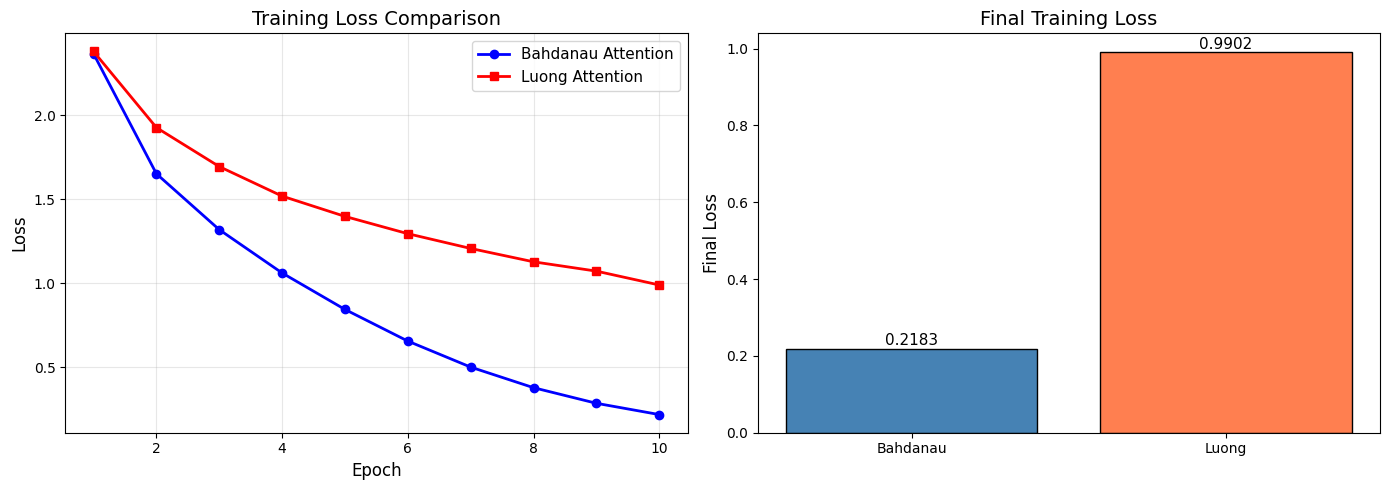

✓ Comparison plot saved


In [84]:
# Plot training loss comparison
plt.figure(figsize=(14, 5))

# Loss curves
plt.subplot(1, 2, 1)
epochs_range = range(1, len(history_bahdanau['loss']) + 1)
plt.plot(epochs_range, history_bahdanau['loss'], 'b-o', label='Bahdanau Attention', linewidth=2)
plt.plot(epochs_range, history_luong['loss'], 'r-s', label='Luong Attention', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Final loss comparison
plt.subplot(1, 2, 2)
final_losses = [history_bahdanau['loss'][-1], history_luong['loss'][-1]]
bars = plt.bar(['Bahdanau', 'Luong'], final_losses, color=['steelblue', 'coral'], edgecolor='black')
plt.ylabel('Final Loss', fontsize=12)
plt.title('Final Training Loss', fontsize=14)
for bar, loss in zip(bars, final_losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{loss:.4f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved")

In [85]:
# Summary Report
print("="*60)
print("COMPARISON RESULTS")
print("="*60)
print(f"\nBahdanau Attention:")
print(f"  Initial Loss: {history_bahdanau['loss'][0]:.4f}")
print(f"  Final Loss:   {history_bahdanau['loss'][-1]:.4f}")
print(f"  Improvement:  {history_bahdanau['loss'][0] - history_bahdanau['loss'][-1]:.4f}")

print(f"\nLuong Attention:")
print(f"  Initial Loss: {history_luong['loss'][0]:.4f}")
print(f"  Final Loss:   {history_luong['loss'][-1]:.4f}")
print(f"  Improvement:  {history_luong['loss'][0] - history_luong['loss'][-1]:.4f}")

winner = "Bahdanau" if history_bahdanau['loss'][-1] < history_luong['loss'][-1] else "Luong"
diff = abs(history_bahdanau['loss'][-1] - history_luong['loss'][-1])
print(f"\n{'='*60}")
print(f"Better Performance: {winner} (by {diff:.4f} loss)")
print("="*60)

COMPARISON RESULTS

Bahdanau Attention:
  Initial Loss: 2.3672
  Final Loss:   0.2183
  Improvement:  2.1490

Luong Attention:
  Initial Loss: 2.3810
  Final Loss:   0.9902
  Improvement:  1.3908

Better Performance: Bahdanau (by 0.7719 loss)


## Key Differences

### Bahdanau (Additive) Attention:
- Uses feedforward neural network to compute attention scores
- More parameters to learn (W1, W2, V)
- Can capture more complex alignment patterns
- Computationally more expensive

### Luong (Multiplicative) Attention:
- Uses dot product or simple weight matrix for scores
- Fewer parameters (just W for 'general')
- Computationally more efficient
- Often performs similarly to Bahdanau

## Conclusion
Both attention mechanisms are effective for sequence-to-sequence tasks. The choice between them often depends on:
- Computational budget
- Dataset characteristics  
- Required model capacity